In [9]:
import torch
import transformers
from transformers import AutoTokenizer, RwkvConfig, RwkvModel
from attn_vis_utils import normalize_attn_mat
import matplotlib.pyplot as plt

In [10]:
model = RwkvModel.from_pretrained("sgugger/rwkv-430M-pile")
tokenizer = AutoTokenizer.from_pretrained("sgugger/rwkv-430M-pile")
prompt = "Alice was beginning to get very tired of sitting by her sister on the bank"#, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, “and what is the use of a book,” thought Alice “without pictures or conversations?” So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes"# ran close by her. There was nothing so very remarkable in that; nor did Alice think it so very much out of the way to hear the Rabbit say to itself, “Oh dear! Oh dear! I shall be late!” (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually took a watch out of its waistcoat-pocket, and looked at it, and then hurried on, Alice started to her feet, for it flashed across her mind that she had never before seen a rabbit with either a waistcoat-pocket, or a watch to take out of it, and burning with curiosity, she ran across the field after it, and fortunately was just in time to see it pop down a large rabbit-hole under the hedge. In another moment down went Alice after it, never once considering how in the world she was to get out again. The rabbit-hole went straight on like a tunnel for some way, and then dipped suddenly down, so suddenly that Alice had not a moment to think about stopping herself before she found herself falling down a very deep well. Either the well was very deep, or she fell very slowly, for she had plenty of time as she went down to look about her and to wonder what was going to happen next. First, she tried to look down and make out what she was coming to, but it was too dark to see anything; then she looked at the sides of the well, and noticed that they were filled with cupboards and book-shelves; here and there she saw maps and pictures hung upon pegs. She took down a jar from one of the shelves as she passed; it was labelled “ORANGE MARMALADE”, but to her great disappointment it was empty: she did not like to drop the jar for fear of killing somebody underneath, so managed to put it"
prompt = "Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into"# the book her sister was reading, but it had no pictures or conversations in it, “and what is the use of a book,” thought Alice “without pictures or conversations?” So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes"# ran close by her. There was nothing so very remarkable in that; nor did Alice think it so very much out of the way to hear the Rabbit say to itself, “Oh dear! Oh dear! I shall be late!” (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually took a watch out of its waistcoat-pocket, and looked at it, and then hurried on, Alice started to her feet, for it flashed across her mind that she had never before seen a rabbit with either a waistcoat-pocket, or a watch to take out of it, and burning with curiosity, she ran across the field after it, and fortunately was just in time to see it pop down a large rabbit-hole under the hedge. In another moment down went Alice after it, never once considering how in the world she was to get out again. The rabbit-hole went straight on like a tunnel for some way, and then dipped suddenly down, so suddenly that Alice had not a moment to think about stopping herself before she found herself falling down a very deep well. Either the well was very deep, or she fell very slowly, for she had plenty of time as she went down to look about her and to wonder what was going to happen next. First, she tried to look down and make out what she was coming to, but it was too dark to see anything; then she looked at the sides of the well, and noticed that they were filled with cupboards and book-shelves; here and there she saw maps and pictures hung upon pegs. She took down a jar from one of the shelves as she passed; it was labelled “ORANGE MARMALADE”, but to her great disappointment it was empty: she did not like to drop the jar for fear of killing somebody underneath, so managed to put it"
inputs = tokenizer(prompt, return_tensors="pt")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
selected_layer = 21
selected_chan = [0,1,2,3,1000,1001,1002,1003]
model.blocks[selected_layer].attention.compute_attn_matrix = True
model.blocks[selected_layer].attention.ablate_gate = False

In [12]:
outputs = model(inputs["input_ids"])
attn_mat = model.blocks[selected_layer].attention.attn_matrix

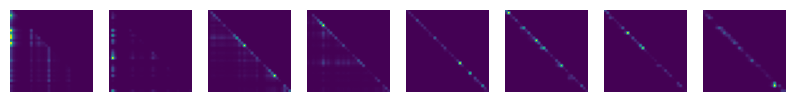

In [13]:
fig, axs = plt.subplots(1, len(selected_chan), figsize=(10,10))
for i,c in enumerate(selected_chan):
    curr_attn_mat = normalize_attn_mat(attn_mat[0,c,:,:].abs())
    axs[i].imshow(curr_attn_mat.cpu().detach().numpy())
    axs[i].axis('off')
model.blocks[selected_layer].attention.compute_attn_matrix = False

## Visualization of Ablation variant (without gate brnach)

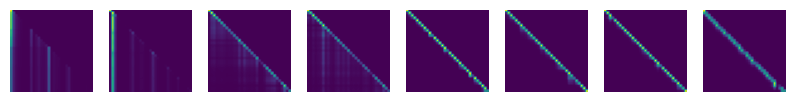

In [14]:
model.blocks[selected_layer].attention.ablate_gate = True
model.blocks[selected_layer].attention.compute_attn_matrix = True
outputs = model(inputs["input_ids"])
attn_mat = model.blocks[selected_layer].attention.attn_matrix
fig, axs = plt.subplots(1, len(selected_chan), figsize=(10,10))
for i,c in enumerate(selected_chan):
    curr_attn_mat = normalize_attn_mat(attn_mat[0,c,:,:].abs())
    axs[i].imshow(curr_attn_mat.cpu().detach().numpy())
    axs[i].axis('off')
model.blocks[selected_layer].attention.compute_attn_matrix = False
model.blocks[selected_layer].attention.ablate_gate = False

In [ ]:
def save_attention_matrix(attn_matrix, channel_index):
    plt.figure(figsize=(6, 6))  # Create a new figure for the matrix
    plt.imshow(attn_matrix.cpu().detach().numpy(), cmap='viridis')  # Display the matrix using a color map
    plt.axis('off')  # Hide the axes
    #plt.colorbar()  # Optionally add a colorbar to indicate the scale
    filepath = f'RWKV_attention_map_layer_{selected_layer}_channel_{channel_index}.png'  # Name the file based on the channel index
    plt.savefig(filepath, dpi=300, bbox_inches='tight')  # Save the figure to a file
    plt.close()  # Close the figure to free up memory

for c in range(100):
    curr_attn_mat = normalize_attn_mat(attn_mat[0, c, :, :].abs())
    save_attention_matrix(curr_attn_mat, c)  #

## Compute Attention vector (CLS to others)

In [15]:
selected_layer = 14
model = RwkvModel.from_pretrained("sgugger/rwkv-430M-pile")
model.blocks[selected_layer].attention.compute_attn_vec = True
model.blocks[selected_layer].attention.ablate_gate = False
selected_chan = [30,31,32,33]
outputs = model(inputs["input_ids"])
attn_vec = model.blocks[selected_layer].attention.attn_vec
fig, axs = plt.subplots(1, len(selected_chan), figsize=(10,10))
attn_vec = normalize_attn_mat(attn_vec[0,:,:].abs())
for i,c in enumerate(selected_chan):
    curr_attn_vec = attn_vec[c:c+1,:]
    axs[i].imshow(curr_attn_vec.cpu().detach().numpy())
    axs[i].axis('off')
model.blocks[selected_layer].attention.compute_attn_vector = False